In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

In [11]:
# Define the Neural Network Model using Batch Normalization

class NetBatchNorm(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(NetBatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
    # Prediction
    def forward(self, x):
        x = self.bn1(torch.sigmoid(self.linear1(x)))
        x = self.bn2(torch.sigmoid(self.linear2(x)))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.bn1(self.linear1(x))
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.bn2(self.linear2(a1))
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out

In [3]:
class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
    
    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out 

In [5]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs = 100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_accuracy': []}
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
        correct = 0
        for x, y in validation_loader:
            model.eval()
            y_hat = model(x.view(-1, 28 * 28))
            _, label = torch.max(y_hat, 1)
            correct += (label == y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    return useful_stuff

In [6]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

In [7]:
criterion = nn.CrossEntropyLoss()
input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

In [12]:
model_norm = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)
training_results_norm = train(model_norm, criterion, train_loader, validation_loader, optimizer, epochs = 5)

In [13]:
# Create model without Batch Normalization, optimizer and train the model

model = Net(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

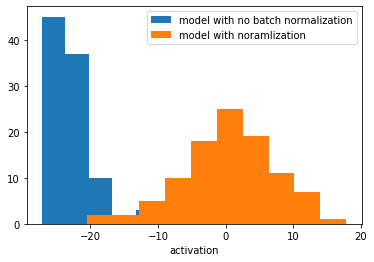

In [15]:
model.eval()
model_norm.eval()
out = model.activation(validation_dataset[0][0].reshape(-1, 28 * 28))
plt.hist(out[2], label = 'model with no batch normalization')
out_norm = model_norm.activation(validation_dataset[0][0].reshape(-1, 28 * 28))
plt.hist(out_norm[2], label = 'model with noramlization')
plt.xlabel('activation')
plt.legend()
plt.show()